# Exercise 4

## Group
- **ID**: 5

- **Members**:
    - Hasan Algafri
    - Emre Dursunluer
    - Taha El Amine Kassabi

## Hand-in
- Please hand in this notebook with your code implementation via Ilias
- Please make sure that there is exactly **one** submission per group

## Task Description

Apply Proximal Policy Optimization to fine-tune the pretrained GPT-2 Medium model so that it excels at simple addition problems with operands from 0 to 100 (or 0 to 50). Define a reward that reflects arithmetic correctness, train the model with the PPO algorithm, and track the key loss components throughout training. Finally, visualize how the policy loss, value loss, and entropy loss evolve over the course of optimization.

## Grading scheme
Total: 5 points
1. **Preparing the Dataloader and the Model** (1.5 points)
2. **PPO training loop** (3 points)
3. **Visulization** (0.5 points)

In [1]:
import os
import re
from copy import deepcopy
from functools import partial

import torch
from torch import nn, optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader, IterableDataset
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
from tqdm.auto import trange

torch.manual_seed(42)

/opt/homebrew/anaconda3/envs/advanced-deep-learning/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/envs/advanced-deep-learning/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/homebrew/anaconda3/envs/advanced-deep-learning/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <473B02F4-48EA-3880-8B82-14AA228F6939> /opt/homebrew/anaconda3/envs/advanced-deep-learning/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Task 1: Data and Model

In [2]:
class AdditionDataset(IterableDataset):
    def __init__(self, min=0, max=100):
        self.min = min
        self.max = max

    def __iter__(self):
        while True:
            yield self.sample()

    def sample(self):
        a, b = torch.randint(self.min, self.max, [2])
        return f'{a}+{b}=', (a + b).item()

In [3]:
def custom_collate_fn(batch, tokenizer):
    prompts, solutions = zip(*batch)

    encoding = tokenizer(
        prompts,
        padding='longest',
        truncation=True,
        return_tensors='pt',
        return_attention_mask=True,
        add_special_tokens=True
    )

    return {
        'prompts': prompts,
        'input_ids': encoding.input_ids,
        'solutions': torch.as_tensor(solutions),
    }

In [4]:
class GPT2ActorCritic(nn.Module):
    def __init__(self, lm, tokenizer, max_gen_len, clip_epsilon, entropy_coef, max_error):
        super().__init__()
        self.lm = lm
        self.tokenizer = tokenizer
        self.critic = nn.Linear(self.lm.config.hidden_size, 1)

        self.max_gen_len = max_gen_len
        self.re_pattern = re.compile(r'^\d+\+\d+\=\s*(\d+)\s*$')

        self.clip_epsilon = clip_epsilon
        self.entropy_coef = entropy_coef
        self.max_error = max_error

    def forward(self, input_ids, solutions, old_model):
        value = self.compute_value(input_ids)
        output_ids, log_prob, log_prob_old, entropy = self.generate(input_ids, old_model)
        output = self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        predictions = self.extract_predictions(output)
        mae, reward = self.compute_rewards(predictions, solutions)
        advantage = reward - value.detach()
        loss_outputs = self.compute_loss(log_prob, log_prob_old, value, reward, advantage)

        return loss_outputs | {
            'entropy_loss': self.entropy_coef * entropy.mean(),
            'reward': reward,
            'mean_absolute_error': mae,
            'malformed': predictions.isnan().sum(),
            'output': output,
        }

    def compute_value(self, input_ids):
        last_hidden = self.lm(input_ids, output_hidden_states=True).hidden_states[-1]
        return self.critic(last_hidden)[:, -1].squeeze(-1)

    def generate(self, input_ids, old_model):
        batch_size = input_ids.size(0)
        eos_token_id = self.tokenizer.eos_token_id
        device = input_ids.device

        batch_output = []
        batch_entropy = torch.zeros(batch_size, device=device)
        batch_log_prob = torch.zeros(batch_size, device=device)
        batch_log_prob_old = torch.zeros(batch_size, device=device)

        done = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for _ in range(self.max_gen_len):
            output = self.lm(input_ids)
            logits_t = output.logits[:, -1, :]

            output_old = old_model.lm(input_ids)
            logits_old_t = output_old.logits[:, -1, :]

            dist = Categorical(logits=logits_t)
            action = dist.sample()
            entropy = dist.entropy()
            log_prob = dist.log_prob(action)

            dist_old = Categorical(logits=logits_old_t)
            log_prob_old = dist_old.log_prob(action)

            next_token = torch.where(done, eos_token_id, action)
            batch_output.append(next_token)

            batch_entropy[~done] += entropy[~done]
            batch_log_prob[~done] += log_prob[~done]
            batch_log_prob_old[~done] += log_prob_old[~done]

            input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=1)

            done |= next_token == eos_token_id
            if done.all(): break

        return input_ids, batch_log_prob, batch_log_prob_old, batch_entropy

    def extract_predictions(self, outputs):
        def extract_prediction(output):
            match = self.re_pattern.search(output)
            return int(match.group(1)) if match else torch.nan

        device = next(iter(self.parameters())).device
        return torch.as_tensor([extract_prediction(out) for out in outputs], device=device)

    def compute_rewards(self, predictions, solutions):
        mae = abs(predictions - solutions)
        reward = (1 - 2 * (mae / self.max_error) ** 2).clamp(-1, 1)

        mae = torch.where(mae.isnan(), self.max_error, mae).clamp(max=self.max_error)
        reward = torch.where(mae == 0, 2, reward)
        reward = torch.where(reward.isnan(), -2, reward)

        return mae.float(), reward / 2

    def compute_loss(self, log_prob, log_prob_old, value, reward, advantage):
        ratio = (log_prob - log_prob_old).exp()
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * advantage

        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = (value - reward).pow(2).mean()

        return {
            'actor_loss': actor_loss,
            'critic_loss': critic_loss,
        }

In [5]:
class Configuration:
    def __init__(self):
        self.num_steps = 20000
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')

        self.pseudo_epoch_steps = 100
        self.model_update_steps = 5

        min_smnd, max_smnd = 0, 100
        max_error = 2 * (max_smnd - min_smnd)

        self.lm_name = 'gpt2-medium'
        self.tokenizer = GPT2Tokenizer.from_pretrained(self.lm_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        clip_epsilon = 0.2
        entropy_coef = 0.01
        max_gen_len = 1
        get_model = lambda: GPT2ActorCritic(self.get_lm(), self.tokenizer, max_gen_len, clip_epsilon, entropy_coef, max_error).to(self.device)
        self.model = get_model()
        self.old_model = get_model()
        for p in self.old_model.parameters(): p.requires_grad_(False)

        lr = 1e-6
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr)

        collate_fn = partial(custom_collate_fn, tokenizer=self.tokenizer)

        num_workers = os.cpu_count() if self.device.type == 'cuda' else 0
        batch_size = 8
        ds = AdditionDataset(min_smnd, max_smnd)
        self.dl = DataLoader(ds, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

        self.model_path = '../models/ex04_best_model_min_loss.pt'

    def get_lm(self):
        lm = GPT2LMHeadModel.from_pretrained(self.lm_name)
        lm.config.use_cache = True
        return lm

`max_gen_len` can be safely set to 1 since all numbers up to 200 definitely have a token. See the following:

In [6]:
assert Configuration().tokenizer(np.arange(201).astype(str).tolist(), return_tensors='np').input_ids.shape == (201, 1)

## Task 2:

In [7]:
def log_pseudo_epoch(step, pes, batch_size, avg_total_loss, mae, correct, malformed):
    recent_mae = np.mean(mae[-pes:])
    recent_malformed = np.sum(malformed[-pes:])
    recent_correct = np.sum(correct[-pes:])
    print(
        f'[Pseudo-Epoch {step // pes}] '
        f'Total loss: {avg_total_loss:.4f} | '
        f'Malformed: {recent_malformed}/{pes * batch_size} | '
        f'MAE: {recent_mae:.2f} | '
        f'Accuracy: {recent_correct / (pes * batch_size):.2%}'
    )


def train(config):
    model = config.model
    old_model = config.old_model
    optimizer = config.optimizer
    dl = config.dl
    batch_size = dl.batch_size
    device = config.device
    num_steps = config.num_steps
    os.makedirs(os.path.dirname(config.model_path), exist_ok=True)

    pes, mus = config.pseudo_epoch_steps, config.model_update_steps

    model.train()

    mae = []
    correct = []
    malformed = []

    actor_loss = []
    critic_loss = []
    entropy_loss = []
    total_loss = []

    best_loss = float('inf')

    for i, batch in zip(trange(1, 1 + num_steps), dl):
        input_ids = batch['input_ids'].to(device)
        solutions = batch['solutions'].to(device)

        outputs = model(input_ids, solutions, old_model)

        actor_loss += [outputs['actor_loss']]
        critic_loss += [outputs['critic_loss']]
        entropy_loss += [outputs['entropy_loss']]
        loss = actor_loss[-1] + critic_loss[-1] + entropy_loss[-1]
        total_loss += [loss.item()]

        mae += [outputs['mean_absolute_error'].detach().mean().item()]
        correct += [(outputs['mean_absolute_error'].detach() == 0).sum().item()]
        malformed += [outputs['malformed'].item()]

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        if i % mus == 0: old_model.load_state_dict(model.state_dict())
        avg_total_loss = np.mean(total_loss[-pes:])
        if i % pes == 0:
            log_pseudo_epoch(i, pes, batch_size, avg_total_loss, mae, correct, malformed)
        if i == num_steps or i % (pes * 10) == 0 and avg_total_loss < best_loss:
            best_loss = avg_total_loss
            torch.save({
                'step_num': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_total_loss,
            }, config.model_path)

    return {
        'actor_loss': torch.as_tensor(actor_loss),
        'critic_loss': torch.as_tensor(critic_loss),
        'entropy_loss': torch.as_tensor(entropy_loss),
        'total_loss': torch.as_tensor(total_loss),
        'mean_absolute_error': torch.as_tensor(mae),
        'accuracy': torch.as_tensor(correct) / batch_size,
    }

In [8]:
config = Configuration()
log = train(config)

  0%|          | 0/20000 [00:00<?, ?it/s]

[Pseudo-Epoch 1] Total loss: 4.3279 | Malformed: 341/800 | MAE: 136.65 | Accuracy: 0.25%


[Pseudo-Epoch 2] Total loss: 0.8970 | Malformed: 60/800 | MAE: 94.70 | Accuracy: 0.00%


[Pseudo-Epoch 3] Total loss: 0.5225 | Malformed: 26/800 | MAE: 83.28 | Accuracy: 0.25%


[Pseudo-Epoch 4] Total loss: 0.4286 | Malformed: 5/800 | MAE: 63.59 | Accuracy: 0.62%


[Pseudo-Epoch 5] Total loss: 0.5833 | Malformed: 3/800 | MAE: 47.30 | Accuracy: 0.88%


[Pseudo-Epoch 6] Total loss: 0.5182 | Malformed: 0/800 | MAE: 37.38 | Accuracy: 0.88%


[Pseudo-Epoch 7] Total loss: 0.2826 | Malformed: 0/800 | MAE: 35.78 | Accuracy: 1.00%


[Pseudo-Epoch 8] Total loss: 0.2687 | Malformed: 0/800 | MAE: 34.86 | Accuracy: 1.12%


[Pseudo-Epoch 9] Total loss: 0.2728 | Malformed: 0/800 | MAE: 32.42 | Accuracy: 1.12%


[Pseudo-Epoch 10] Total loss: 0.2513 | Malformed: 0/800 | MAE: 32.98 | Accuracy: 0.62%


[Pseudo-Epoch 11] Total loss: 0.1358 | Malformed: 0/800 | MAE: 33.60 | Accuracy: 0.50%


[Pseudo-Epoch 12] Total loss: 0.1274 | Malformed: 0/800 | MAE: 33.17 | Accuracy: 1.62%


[Pseudo-Epoch 13] Total loss: 0.1018 | Malformed: 0/800 | MAE: 35.74 | Accuracy: 0.62%


[Pseudo-Epoch 14] Total loss: 0.2274 | Malformed: 1/800 | MAE: 34.77 | Accuracy: 1.25%


[Pseudo-Epoch 15] Total loss: 0.0926 | Malformed: 0/800 | MAE: 34.75 | Accuracy: 0.50%


[Pseudo-Epoch 16] Total loss: 0.0965 | Malformed: 0/800 | MAE: 34.03 | Accuracy: 0.50%


[Pseudo-Epoch 17] Total loss: 0.0592 | Malformed: 0/800 | MAE: 33.91 | Accuracy: 0.75%


[Pseudo-Epoch 18] Total loss: 0.0660 | Malformed: 0/800 | MAE: 34.20 | Accuracy: 1.38%


[Pseudo-Epoch 19] Total loss: 0.0613 | Malformed: 0/800 | MAE: 33.30 | Accuracy: 1.12%


[Pseudo-Epoch 20] Total loss: 0.0624 | Malformed: 0/800 | MAE: 33.40 | Accuracy: 1.12%


[Pseudo-Epoch 21] Total loss: 0.0638 | Malformed: 0/800 | MAE: 34.03 | Accuracy: 0.88%


[Pseudo-Epoch 22] Total loss: 0.0511 | Malformed: 0/800 | MAE: 33.73 | Accuracy: 0.88%


[Pseudo-Epoch 23] Total loss: 0.0415 | Malformed: 0/800 | MAE: 34.68 | Accuracy: 1.25%


[Pseudo-Epoch 24] Total loss: 0.0446 | Malformed: 0/800 | MAE: 34.48 | Accuracy: 0.50%


[Pseudo-Epoch 25] Total loss: 0.0343 | Malformed: 0/800 | MAE: 33.95 | Accuracy: 1.62%


[Pseudo-Epoch 26] Total loss: 0.0674 | Malformed: 1/800 | MAE: 33.32 | Accuracy: 1.38%


[Pseudo-Epoch 27] Total loss: 0.0390 | Malformed: 0/800 | MAE: 34.41 | Accuracy: 0.50%


[Pseudo-Epoch 28] Total loss: 0.0297 | Malformed: 0/800 | MAE: 33.47 | Accuracy: 0.62%


[Pseudo-Epoch 29] Total loss: 0.0315 | Malformed: 0/800 | MAE: 32.66 | Accuracy: 0.62%


[Pseudo-Epoch 30] Total loss: 0.0385 | Malformed: 0/800 | MAE: 33.95 | Accuracy: 1.88%


[Pseudo-Epoch 31] Total loss: 0.0293 | Malformed: 0/800 | MAE: 34.02 | Accuracy: 1.00%


[Pseudo-Epoch 32] Total loss: 0.0339 | Malformed: 0/800 | MAE: 34.16 | Accuracy: 1.50%


[Pseudo-Epoch 33] Total loss: 0.0350 | Malformed: 0/800 | MAE: 32.67 | Accuracy: 1.12%


[Pseudo-Epoch 34] Total loss: 0.0258 | Malformed: 0/800 | MAE: 33.26 | Accuracy: 0.75%


[Pseudo-Epoch 35] Total loss: 0.0421 | Malformed: 1/800 | MAE: 35.11 | Accuracy: 1.00%


[Pseudo-Epoch 36] Total loss: 0.0288 | Malformed: 0/800 | MAE: 33.19 | Accuracy: 2.50%


[Pseudo-Epoch 37] Total loss: 0.0186 | Malformed: 0/800 | MAE: 33.87 | Accuracy: 0.75%


[Pseudo-Epoch 38] Total loss: 0.0202 | Malformed: 0/800 | MAE: 32.59 | Accuracy: 0.88%


[Pseudo-Epoch 39] Total loss: 0.0170 | Malformed: 0/800 | MAE: 33.53 | Accuracy: 1.25%


[Pseudo-Epoch 40] Total loss: 0.0177 | Malformed: 0/800 | MAE: 32.85 | Accuracy: 1.25%


[Pseudo-Epoch 41] Total loss: 0.0244 | Malformed: 0/800 | MAE: 33.94 | Accuracy: 1.00%


[Pseudo-Epoch 42] Total loss: 0.0257 | Malformed: 0/800 | MAE: 34.62 | Accuracy: 1.25%


[Pseudo-Epoch 43] Total loss: 0.0243 | Malformed: 0/800 | MAE: 33.26 | Accuracy: 0.75%


[Pseudo-Epoch 44] Total loss: 0.0178 | Malformed: 0/800 | MAE: 33.85 | Accuracy: 0.88%


[Pseudo-Epoch 45] Total loss: 0.0212 | Malformed: 0/800 | MAE: 33.45 | Accuracy: 0.88%


[Pseudo-Epoch 46] Total loss: 0.0251 | Malformed: 0/800 | MAE: 33.66 | Accuracy: 0.75%


[Pseudo-Epoch 47] Total loss: 0.0137 | Malformed: 0/800 | MAE: 34.02 | Accuracy: 0.88%


[Pseudo-Epoch 48] Total loss: 0.0193 | Malformed: 0/800 | MAE: 35.43 | Accuracy: 1.25%


[Pseudo-Epoch 49] Total loss: 0.0224 | Malformed: 0/800 | MAE: 34.47 | Accuracy: 1.38%


[Pseudo-Epoch 50] Total loss: 0.0160 | Malformed: 0/800 | MAE: 34.24 | Accuracy: 1.12%


[Pseudo-Epoch 51] Total loss: 0.0346 | Malformed: 1/800 | MAE: 33.49 | Accuracy: 0.50%


[Pseudo-Epoch 52] Total loss: 0.0254 | Malformed: 1/800 | MAE: 34.30 | Accuracy: 1.12%


[Pseudo-Epoch 53] Total loss: 0.0147 | Malformed: 0/800 | MAE: 33.80 | Accuracy: 1.00%


[Pseudo-Epoch 54] Total loss: 0.0142 | Malformed: 0/800 | MAE: 34.01 | Accuracy: 0.88%


[Pseudo-Epoch 55] Total loss: 0.0215 | Malformed: 1/800 | MAE: 33.63 | Accuracy: 0.62%


[Pseudo-Epoch 56] Total loss: 0.0233 | Malformed: 1/800 | MAE: 33.55 | Accuracy: 1.12%


[Pseudo-Epoch 57] Total loss: 0.0193 | Malformed: 0/800 | MAE: 32.58 | Accuracy: 1.12%


[Pseudo-Epoch 58] Total loss: 0.0151 | Malformed: 0/800 | MAE: 34.38 | Accuracy: 1.00%


[Pseudo-Epoch 59] Total loss: 0.0155 | Malformed: 0/800 | MAE: 33.30 | Accuracy: 0.62%


[Pseudo-Epoch 60] Total loss: 0.0196 | Malformed: 1/800 | MAE: 33.94 | Accuracy: 0.88%


[Pseudo-Epoch 61] Total loss: 0.0159 | Malformed: 0/800 | MAE: 34.31 | Accuracy: 1.50%


[Pseudo-Epoch 62] Total loss: 0.0188 | Malformed: 0/800 | MAE: 33.59 | Accuracy: 0.62%


[Pseudo-Epoch 63] Total loss: 0.0183 | Malformed: 0/800 | MAE: 35.25 | Accuracy: 0.75%


[Pseudo-Epoch 64] Total loss: 0.0160 | Malformed: 0/800 | MAE: 35.05 | Accuracy: 0.62%


[Pseudo-Epoch 65] Total loss: 0.0117 | Malformed: 0/800 | MAE: 34.23 | Accuracy: 0.88%


[Pseudo-Epoch 66] Total loss: 0.0135 | Malformed: 0/800 | MAE: 34.39 | Accuracy: 0.62%


[Pseudo-Epoch 67] Total loss: 0.0166 | Malformed: 0/800 | MAE: 35.13 | Accuracy: 1.00%


[Pseudo-Epoch 68] Total loss: 0.0205 | Malformed: 1/800 | MAE: 34.74 | Accuracy: 1.00%


[Pseudo-Epoch 69] Total loss: 0.0117 | Malformed: 0/800 | MAE: 34.22 | Accuracy: 0.50%


[Pseudo-Epoch 70] Total loss: 0.0250 | Malformed: 1/800 | MAE: 34.85 | Accuracy: 1.25%


[Pseudo-Epoch 71] Total loss: 0.0119 | Malformed: 0/800 | MAE: 34.33 | Accuracy: 0.75%


[Pseudo-Epoch 72] Total loss: 0.0137 | Malformed: 0/800 | MAE: 35.13 | Accuracy: 0.50%


[Pseudo-Epoch 73] Total loss: 0.0106 | Malformed: 0/800 | MAE: 33.14 | Accuracy: 0.88%


[Pseudo-Epoch 74] Total loss: 0.0087 | Malformed: 0/800 | MAE: 34.21 | Accuracy: 1.38%


[Pseudo-Epoch 75] Total loss: 0.0085 | Malformed: 0/800 | MAE: 34.34 | Accuracy: 0.38%


[Pseudo-Epoch 76] Total loss: 0.0088 | Malformed: 0/800 | MAE: 33.60 | Accuracy: 0.75%


[Pseudo-Epoch 77] Total loss: 0.0099 | Malformed: 0/800 | MAE: 33.24 | Accuracy: 0.62%


[Pseudo-Epoch 78] Total loss: 0.0216 | Malformed: 1/800 | MAE: 34.13 | Accuracy: 0.38%


[Pseudo-Epoch 79] Total loss: 0.0039 | Malformed: 0/800 | MAE: 34.84 | Accuracy: 1.00%


[Pseudo-Epoch 80] Total loss: 0.0068 | Malformed: 0/800 | MAE: 33.27 | Accuracy: 0.75%


[Pseudo-Epoch 81] Total loss: 0.0079 | Malformed: 0/800 | MAE: 33.16 | Accuracy: 1.62%


[Pseudo-Epoch 82] Total loss: 0.0088 | Malformed: 0/800 | MAE: 34.41 | Accuracy: 1.00%


[Pseudo-Epoch 83] Total loss: 0.0106 | Malformed: 0/800 | MAE: 33.13 | Accuracy: 1.50%


[Pseudo-Epoch 84] Total loss: 0.0095 | Malformed: 0/800 | MAE: 32.72 | Accuracy: 1.75%


[Pseudo-Epoch 85] Total loss: 0.0092 | Malformed: 0/800 | MAE: 34.84 | Accuracy: 1.25%


[Pseudo-Epoch 86] Total loss: 0.0104 | Malformed: 0/800 | MAE: 33.35 | Accuracy: 1.12%


[Pseudo-Epoch 87] Total loss: 0.0107 | Malformed: 0/800 | MAE: 36.42 | Accuracy: 0.62%


[Pseudo-Epoch 88] Total loss: 0.0024 | Malformed: 0/800 | MAE: 34.15 | Accuracy: 0.88%


[Pseudo-Epoch 89] Total loss: 0.0059 | Malformed: 0/800 | MAE: 33.43 | Accuracy: 1.12%


[Pseudo-Epoch 90] Total loss: 0.0072 | Malformed: 0/800 | MAE: 33.15 | Accuracy: 1.12%


[Pseudo-Epoch 91] Total loss: 0.0067 | Malformed: 0/800 | MAE: 33.95 | Accuracy: 1.12%


[Pseudo-Epoch 92] Total loss: 0.0029 | Malformed: 0/800 | MAE: 34.37 | Accuracy: 0.62%


[Pseudo-Epoch 93] Total loss: 0.0026 | Malformed: 0/800 | MAE: 33.13 | Accuracy: 0.50%


[Pseudo-Epoch 94] Total loss: 0.0035 | Malformed: 0/800 | MAE: 33.74 | Accuracy: 1.50%


[Pseudo-Epoch 95] Total loss: 0.0071 | Malformed: 0/800 | MAE: 35.10 | Accuracy: 0.62%


[Pseudo-Epoch 96] Total loss: -0.0001 | Malformed: 0/800 | MAE: 32.70 | Accuracy: 1.00%


[Pseudo-Epoch 97] Total loss: 0.0041 | Malformed: 0/800 | MAE: 33.09 | Accuracy: 0.88%


[Pseudo-Epoch 98] Total loss: 0.0062 | Malformed: 0/800 | MAE: 34.73 | Accuracy: 1.00%


[Pseudo-Epoch 99] Total loss: 0.0046 | Malformed: 0/800 | MAE: 33.06 | Accuracy: 1.12%


[Pseudo-Epoch 100] Total loss: 0.0064 | Malformed: 0/800 | MAE: 33.81 | Accuracy: 0.50%


[Pseudo-Epoch 101] Total loss: 0.0113 | Malformed: 0/800 | MAE: 33.31 | Accuracy: 1.62%


[Pseudo-Epoch 102] Total loss: 0.0074 | Malformed: 0/800 | MAE: 34.51 | Accuracy: 1.25%


[Pseudo-Epoch 103] Total loss: 0.0026 | Malformed: 0/800 | MAE: 33.49 | Accuracy: 1.38%


[Pseudo-Epoch 104] Total loss: 0.0038 | Malformed: 0/800 | MAE: 34.42 | Accuracy: 1.00%


[Pseudo-Epoch 105] Total loss: 0.0053 | Malformed: 0/800 | MAE: 35.33 | Accuracy: 1.25%


[Pseudo-Epoch 106] Total loss: 0.0045 | Malformed: 0/800 | MAE: 34.84 | Accuracy: 1.00%


[Pseudo-Epoch 107] Total loss: 0.0059 | Malformed: 0/800 | MAE: 35.58 | Accuracy: 1.00%


[Pseudo-Epoch 108] Total loss: 0.0112 | Malformed: 1/800 | MAE: 33.43 | Accuracy: 1.25%


[Pseudo-Epoch 109] Total loss: 0.0046 | Malformed: 0/800 | MAE: 33.46 | Accuracy: 1.00%


[Pseudo-Epoch 110] Total loss: 0.0034 | Malformed: 0/800 | MAE: 35.02 | Accuracy: 0.50%


[Pseudo-Epoch 111] Total loss: 0.0069 | Malformed: 0/800 | MAE: 34.60 | Accuracy: 0.62%


[Pseudo-Epoch 112] Total loss: 0.0055 | Malformed: 0/800 | MAE: 33.52 | Accuracy: 1.00%


[Pseudo-Epoch 113] Total loss: 0.0038 | Malformed: 0/800 | MAE: 33.57 | Accuracy: 0.75%


[Pseudo-Epoch 114] Total loss: 0.0019 | Malformed: 0/800 | MAE: 34.96 | Accuracy: 1.12%


[Pseudo-Epoch 115] Total loss: 0.0054 | Malformed: 0/800 | MAE: 33.76 | Accuracy: 0.38%


[Pseudo-Epoch 116] Total loss: 0.0047 | Malformed: 0/800 | MAE: 34.28 | Accuracy: 1.00%


[Pseudo-Epoch 117] Total loss: 0.0013 | Malformed: 0/800 | MAE: 33.98 | Accuracy: 0.50%


[Pseudo-Epoch 118] Total loss: 0.0033 | Malformed: 0/800 | MAE: 33.71 | Accuracy: 0.38%


[Pseudo-Epoch 119] Total loss: -0.0002 | Malformed: 0/800 | MAE: 33.67 | Accuracy: 0.62%


[Pseudo-Epoch 120] Total loss: 0.0031 | Malformed: 0/800 | MAE: 33.44 | Accuracy: 0.88%


[Pseudo-Epoch 121] Total loss: 0.0046 | Malformed: 0/800 | MAE: 34.35 | Accuracy: 1.00%


[Pseudo-Epoch 122] Total loss: 0.0058 | Malformed: 0/800 | MAE: 34.80 | Accuracy: 0.50%


[Pseudo-Epoch 123] Total loss: 0.0013 | Malformed: 0/800 | MAE: 34.55 | Accuracy: 0.75%


[Pseudo-Epoch 124] Total loss: 0.0011 | Malformed: 0/800 | MAE: 34.29 | Accuracy: 1.00%


[Pseudo-Epoch 125] Total loss: 0.0032 | Malformed: 0/800 | MAE: 33.49 | Accuracy: 1.00%


[Pseudo-Epoch 126] Total loss: 0.0019 | Malformed: 0/800 | MAE: 33.91 | Accuracy: 0.88%


[Pseudo-Epoch 127] Total loss: 0.0025 | Malformed: 0/800 | MAE: 33.49 | Accuracy: 1.12%


[Pseudo-Epoch 128] Total loss: 0.0056 | Malformed: 0/800 | MAE: 34.17 | Accuracy: 0.75%


[Pseudo-Epoch 129] Total loss: 0.0013 | Malformed: 0/800 | MAE: 35.80 | Accuracy: 1.25%


[Pseudo-Epoch 130] Total loss: 0.0099 | Malformed: 1/800 | MAE: 35.14 | Accuracy: 1.25%


[Pseudo-Epoch 131] Total loss: 0.0066 | Malformed: 1/800 | MAE: 35.31 | Accuracy: 0.62%


[Pseudo-Epoch 132] Total loss: 0.0045 | Malformed: 0/800 | MAE: 33.19 | Accuracy: 1.38%


[Pseudo-Epoch 133] Total loss: 0.0015 | Malformed: 0/800 | MAE: 33.19 | Accuracy: 1.38%


[Pseudo-Epoch 134] Total loss: 0.0022 | Malformed: 0/800 | MAE: 33.63 | Accuracy: 0.88%


[Pseudo-Epoch 135] Total loss: 0.0054 | Malformed: 0/800 | MAE: 34.23 | Accuracy: 1.12%


[Pseudo-Epoch 136] Total loss: 0.0030 | Malformed: 0/800 | MAE: 33.35 | Accuracy: 0.75%


[Pseudo-Epoch 137] Total loss: -0.0001 | Malformed: 0/800 | MAE: 34.20 | Accuracy: 0.88%


[Pseudo-Epoch 138] Total loss: 0.0005 | Malformed: 0/800 | MAE: 33.85 | Accuracy: 1.25%


[Pseudo-Epoch 139] Total loss: 0.0054 | Malformed: 0/800 | MAE: 32.71 | Accuracy: 1.50%


[Pseudo-Epoch 140] Total loss: 0.0012 | Malformed: 0/800 | MAE: 34.40 | Accuracy: 1.12%


[Pseudo-Epoch 141] Total loss: 0.0052 | Malformed: 0/800 | MAE: 34.81 | Accuracy: 1.00%


[Pseudo-Epoch 142] Total loss: 0.0029 | Malformed: 0/800 | MAE: 31.91 | Accuracy: 1.75%


[Pseudo-Epoch 143] Total loss: 0.0018 | Malformed: 0/800 | MAE: 34.51 | Accuracy: 0.75%


[Pseudo-Epoch 144] Total loss: 0.0041 | Malformed: 0/800 | MAE: 34.24 | Accuracy: 0.88%


[Pseudo-Epoch 145] Total loss: 0.0016 | Malformed: 0/800 | MAE: 34.15 | Accuracy: 1.25%


[Pseudo-Epoch 146] Total loss: 0.0000 | Malformed: 0/800 | MAE: 35.55 | Accuracy: 1.62%


[Pseudo-Epoch 147] Total loss: 0.0011 | Malformed: 0/800 | MAE: 33.74 | Accuracy: 1.00%


[Pseudo-Epoch 148] Total loss: 0.0030 | Malformed: 0/800 | MAE: 32.75 | Accuracy: 1.12%


[Pseudo-Epoch 149] Total loss: 0.0001 | Malformed: 0/800 | MAE: 33.87 | Accuracy: 0.62%


[Pseudo-Epoch 150] Total loss: 0.0012 | Malformed: 0/800 | MAE: 33.08 | Accuracy: 0.75%


[Pseudo-Epoch 151] Total loss: 0.0016 | Malformed: 0/800 | MAE: 34.24 | Accuracy: 0.62%


[Pseudo-Epoch 152] Total loss: 0.0026 | Malformed: 0/800 | MAE: 33.49 | Accuracy: 0.88%


[Pseudo-Epoch 153] Total loss: 0.0015 | Malformed: 0/800 | MAE: 34.47 | Accuracy: 1.12%


[Pseudo-Epoch 154] Total loss: 0.0052 | Malformed: 0/800 | MAE: 32.38 | Accuracy: 1.25%


[Pseudo-Epoch 155] Total loss: 0.0057 | Malformed: 0/800 | MAE: 34.75 | Accuracy: 0.62%


[Pseudo-Epoch 156] Total loss: 0.0006 | Malformed: 0/800 | MAE: 33.45 | Accuracy: 0.88%


[Pseudo-Epoch 157] Total loss: 0.0004 | Malformed: 0/800 | MAE: 33.37 | Accuracy: 0.88%


[Pseudo-Epoch 158] Total loss: 0.0015 | Malformed: 0/800 | MAE: 34.52 | Accuracy: 0.62%


[Pseudo-Epoch 159] Total loss: 0.0014 | Malformed: 0/800 | MAE: 34.15 | Accuracy: 1.00%


[Pseudo-Epoch 160] Total loss: 0.0004 | Malformed: 0/800 | MAE: 34.88 | Accuracy: 0.62%


[Pseudo-Epoch 161] Total loss: -0.0012 | Malformed: 0/800 | MAE: 33.99 | Accuracy: 1.75%


[Pseudo-Epoch 162] Total loss: 0.0044 | Malformed: 0/800 | MAE: 34.37 | Accuracy: 1.12%


[Pseudo-Epoch 163] Total loss: -0.0010 | Malformed: 0/800 | MAE: 34.89 | Accuracy: 1.00%


[Pseudo-Epoch 164] Total loss: 0.0001 | Malformed: 0/800 | MAE: 33.30 | Accuracy: 0.88%


[Pseudo-Epoch 165] Total loss: -0.0007 | Malformed: 0/800 | MAE: 32.51 | Accuracy: 1.62%


[Pseudo-Epoch 166] Total loss: 0.0014 | Malformed: 0/800 | MAE: 33.40 | Accuracy: 0.88%


[Pseudo-Epoch 167] Total loss: 0.0013 | Malformed: 0/800 | MAE: 33.66 | Accuracy: 1.25%


[Pseudo-Epoch 168] Total loss: 0.0017 | Malformed: 0/800 | MAE: 33.89 | Accuracy: 0.75%


[Pseudo-Epoch 169] Total loss: 0.0007 | Malformed: 0/800 | MAE: 33.24 | Accuracy: 0.62%


[Pseudo-Epoch 170] Total loss: 0.0013 | Malformed: 0/800 | MAE: 33.30 | Accuracy: 1.00%


[Pseudo-Epoch 171] Total loss: -0.0013 | Malformed: 0/800 | MAE: 33.60 | Accuracy: 1.00%


[Pseudo-Epoch 172] Total loss: 0.0007 | Malformed: 0/800 | MAE: 33.54 | Accuracy: 1.25%


[Pseudo-Epoch 173] Total loss: 0.0021 | Malformed: 0/800 | MAE: 34.66 | Accuracy: 0.50%


[Pseudo-Epoch 174] Total loss: 0.0016 | Malformed: 0/800 | MAE: 31.65 | Accuracy: 1.62%


[Pseudo-Epoch 175] Total loss: -0.0000 | Malformed: 0/800 | MAE: 33.19 | Accuracy: 1.12%


[Pseudo-Epoch 176] Total loss: 0.0020 | Malformed: 0/800 | MAE: 33.97 | Accuracy: 0.62%


[Pseudo-Epoch 177] Total loss: 0.0014 | Malformed: 0/800 | MAE: 33.95 | Accuracy: 0.62%


[Pseudo-Epoch 178] Total loss: 0.0017 | Malformed: 0/800 | MAE: 34.14 | Accuracy: 0.25%


[Pseudo-Epoch 179] Total loss: 0.0011 | Malformed: 0/800 | MAE: 32.97 | Accuracy: 1.00%


[Pseudo-Epoch 180] Total loss: -0.0022 | Malformed: 0/800 | MAE: 33.57 | Accuracy: 1.25%


[Pseudo-Epoch 181] Total loss: 0.0014 | Malformed: 0/800 | MAE: 34.05 | Accuracy: 0.62%


[Pseudo-Epoch 182] Total loss: 0.0003 | Malformed: 0/800 | MAE: 33.06 | Accuracy: 1.00%


[Pseudo-Epoch 183] Total loss: -0.0007 | Malformed: 0/800 | MAE: 33.02 | Accuracy: 1.00%


[Pseudo-Epoch 184] Total loss: 0.0002 | Malformed: 0/800 | MAE: 34.17 | Accuracy: 0.75%


[Pseudo-Epoch 185] Total loss: 0.0002 | Malformed: 0/800 | MAE: 31.86 | Accuracy: 1.25%


[Pseudo-Epoch 186] Total loss: 0.0007 | Malformed: 0/800 | MAE: 34.02 | Accuracy: 0.50%


[Pseudo-Epoch 187] Total loss: 0.0012 | Malformed: 0/800 | MAE: 34.41 | Accuracy: 1.00%


[Pseudo-Epoch 188] Total loss: 0.0018 | Malformed: 0/800 | MAE: 34.01 | Accuracy: 0.88%


[Pseudo-Epoch 189] Total loss: 0.0003 | Malformed: 0/800 | MAE: 34.31 | Accuracy: 1.12%


[Pseudo-Epoch 190] Total loss: -0.0005 | Malformed: 0/800 | MAE: 34.08 | Accuracy: 1.12%


[Pseudo-Epoch 191] Total loss: 0.0005 | Malformed: 0/800 | MAE: 34.39 | Accuracy: 1.00%


[Pseudo-Epoch 192] Total loss: -0.0017 | Malformed: 0/800 | MAE: 33.51 | Accuracy: 1.50%


[Pseudo-Epoch 193] Total loss: 0.0012 | Malformed: 0/800 | MAE: 33.67 | Accuracy: 0.38%


[Pseudo-Epoch 194] Total loss: -0.0001 | Malformed: 0/800 | MAE: 33.88 | Accuracy: 0.25%


[Pseudo-Epoch 195] Total loss: -0.0007 | Malformed: 0/800 | MAE: 33.93 | Accuracy: 0.88%


[Pseudo-Epoch 196] Total loss: 0.0013 | Malformed: 0/800 | MAE: 33.50 | Accuracy: 0.50%


[Pseudo-Epoch 197] Total loss: 0.0003 | Malformed: 0/800 | MAE: 34.22 | Accuracy: 1.00%


[Pseudo-Epoch 198] Total loss: 0.0008 | Malformed: 0/800 | MAE: 34.49 | Accuracy: 1.00%


[Pseudo-Epoch 199] Total loss: 0.0060 | Malformed: 1/800 | MAE: 33.79 | Accuracy: 0.50%


[Pseudo-Epoch 200] Total loss: -0.0004 | Malformed: 0/800 | MAE: 32.63 | Accuracy: 1.38%


## Task 3: Plot

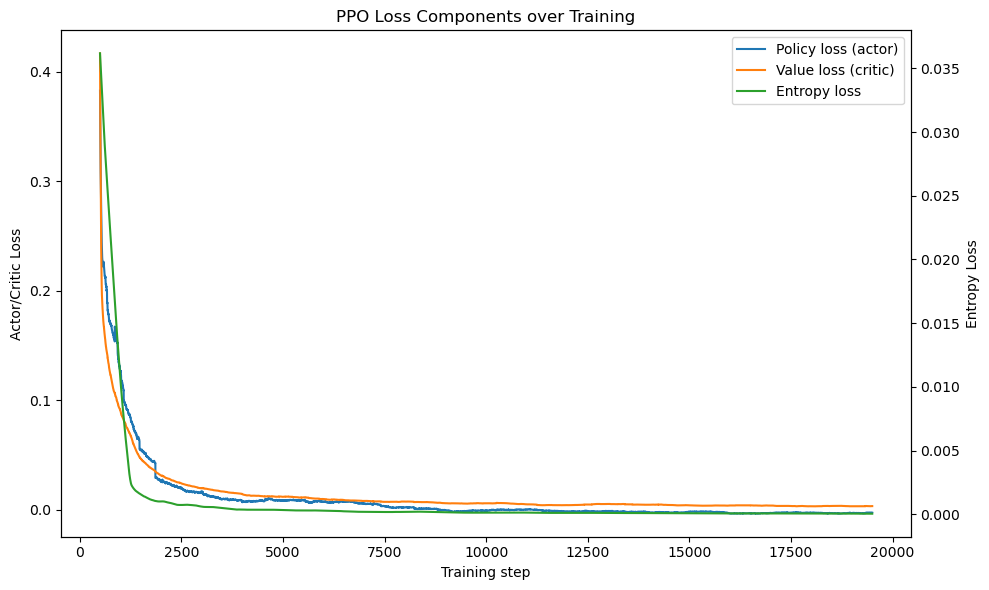

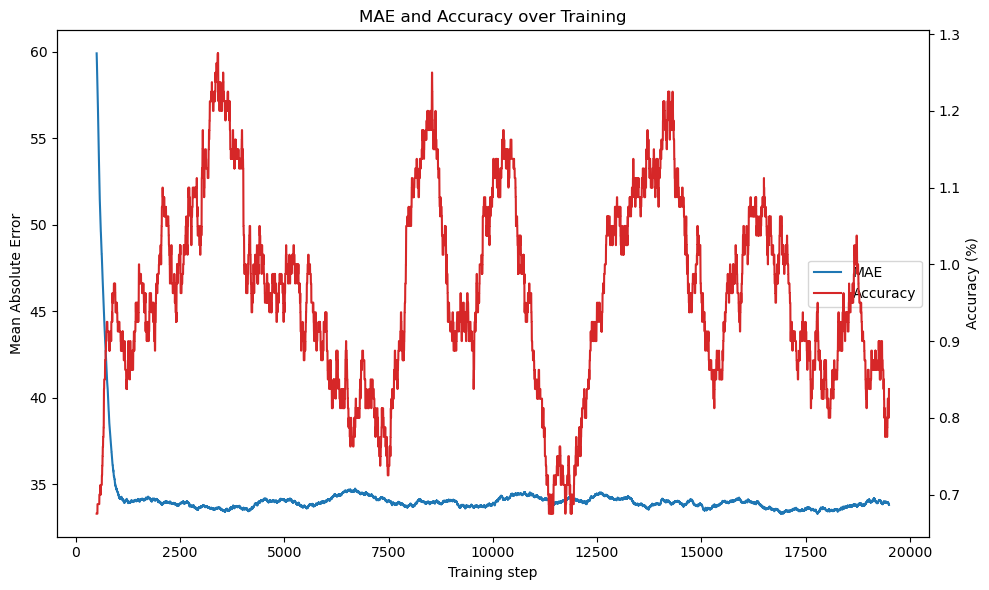

In [9]:
def plot(log):
    moving_average = lambda values, window_size: np.convolve(values, np.ones(window_size) / window_size, mode='valid')

    ws = 1000
    steps = list(range(ws // 2, len(log['actor_loss']) + 1 - ws // 2))

    actor_loss = moving_average(log['actor_loss'], ws)
    critic_loss = moving_average(log['critic_loss'], ws)
    entropy_loss = moving_average(log['entropy_loss'], ws)

    color1 = 'tab:blue'
    color2 = 'tab:orange'
    color3 = 'tab:green'
    color4 = 'tab:red'

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ln1 = ax1.plot(steps, actor_loss, label='Policy loss (actor)', color=color1)
    ln2 = ax1.plot(steps, critic_loss, label='Value loss (critic)', color=color2)
    ax1.set_xlabel('Training step')
    ax1.set_ylabel('Actor/Critic Loss')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ln3 = ax2.plot(steps, entropy_loss, label='Entropy loss', color=color3)
    ax2.set_ylabel('Entropy Loss')
    ax2.tick_params(axis='y')

    lines = ln1 + ln2 + ln3
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels)

    plt.title('PPO Loss Components over Training')
    plt.tight_layout()
    plt.show()

    mae = moving_average(log['mean_absolute_error'], ws)
    accuracy = moving_average(log['accuracy'] * 100, ws)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ln1 = ax1.plot(steps, mae, color=color1, label='MAE')
    ax1.set_xlabel('Training step')
    ax1.set_ylabel('Mean Absolute Error')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ln2 = ax2.plot(steps, accuracy, color=color4, label='Accuracy')
    ax2.set_ylabel('Accuracy (%)')
    ax2.tick_params(axis='y')

    lines = ln1 + ln2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')

    plt.title('MAE and Accuracy over Training')
    fig.tight_layout()
    plt.show()


plot(log)

There is a clear positive trend in accuracy. The MAE improves greatly and keeps on improving.

Possible improvements:
- gradually increase the bonus for perfect answers
- gradually increase the penalty for malformed outputs
- gradually increase the penalty for large errors

A simple reward scheduler should do it. See [my Scheduler implementation](./my_lib/scheduler/showcases/scheduler_showcase.ipynb) here. I'm not going to test it, it was just a fun exercise.